In [ ]:
! unzip "skin cancer.zip"

# **Import needed libraries**

In [ ]:
!pip install tensorflow==2.9.1

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

Read data and store it in dataframe

In [ ]:
! unzip "skin cancer.zip"

In [61]:
data_dir = '/content/data_set/labels/train'
filepaths = []
label_paths = []
labels = []
c = 0
filelist = os.listdir(data_dir)
for file in filelist:
    fpath = os.path.join(data_dir, file)
    label_paths.append(fpath)
    img_path = fpath.replace('labels', 'images')
    filepaths.append(img_path.replace('txt', 'jpg'))

for label in label_paths:
  f = open(label)
  ind = f.read(1)

  if ind == '0':
    labels.append('First Degree')

  elif ind == '1':
    labels.append('Second Degree')

  elif ind == '2':
   labels.append('Third Degree')

  else:
    continue

  f.close()
  c += 1

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [63]:
train_df.dropna(inplace=True)

In [64]:
set(train_df.labels)

{'First Degree', 'Second Degree', 'Third Degree'}

In [69]:
data_dir = '/content/data_set/labels/val'
filepaths = []
label_paths = []
labels = []
c = 0
filelist = os.listdir(data_dir)
for file in filelist:
    if file == 'Data0.cache':
      continue
    fpath = os.path.join(data_dir, file)
    label_paths.append(fpath)
    img_path = fpath.replace('labels', 'images')
    filepaths.append(img_path.replace('txt', 'jpg'))

for label in label_paths:
  f = open(label)
  ind = f.read(1)
  if ind == '0':
    labels.append('First Degree')

  elif ind == '1':
    labels.append('Second Degree')

  elif ind == '2':
   labels.append('Third Degree')

  else:
    continue

  f.close()
  c += 1

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [70]:
test_df.dropna(inplace=True)

In [71]:
set(test_df.labels)

{'First Degree', 'Second Degree', 'Third Degree'}

**Create image data generator**

In [72]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 729 validated image filenames belonging to 3 classes.
Found 243 validated image filenames belonging to 3 classes.


**Show sample from train data**

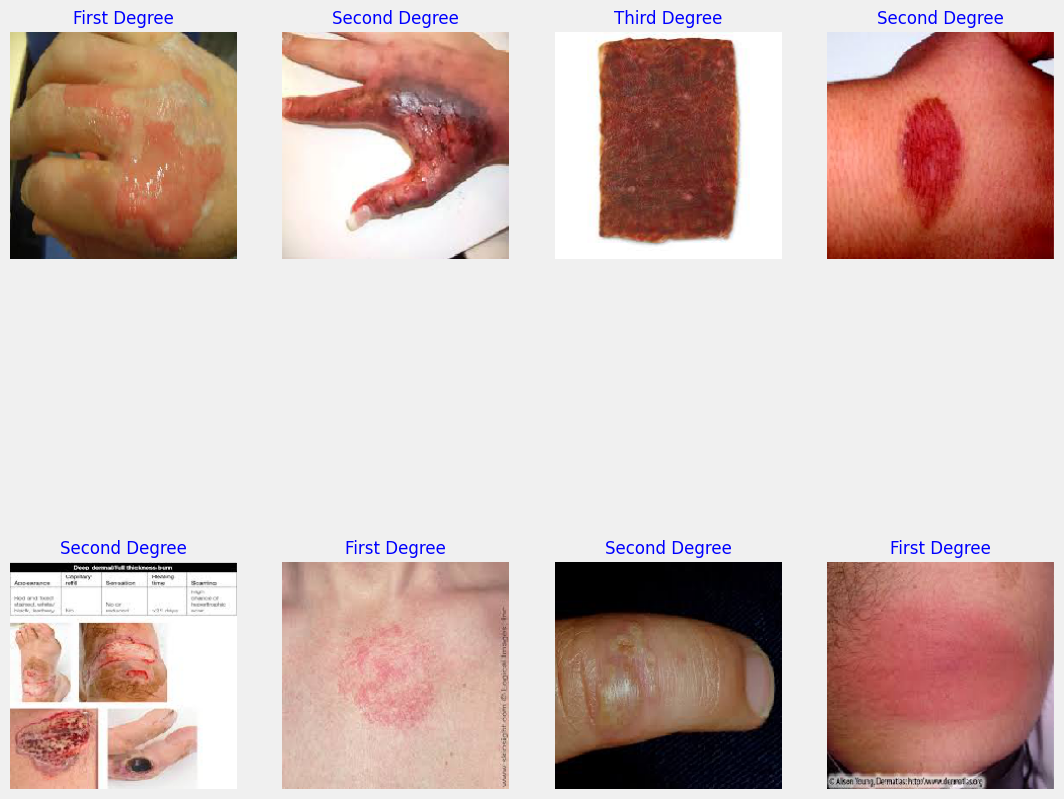

In [73]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (12, 12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

**Generic Model Creation**

In [74]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb5 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_5 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 4,338,815
Non-trainable params: 44,583
_______________________________________

**Train model**

In [ ]:
epochs = 30   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

**Display model performance**

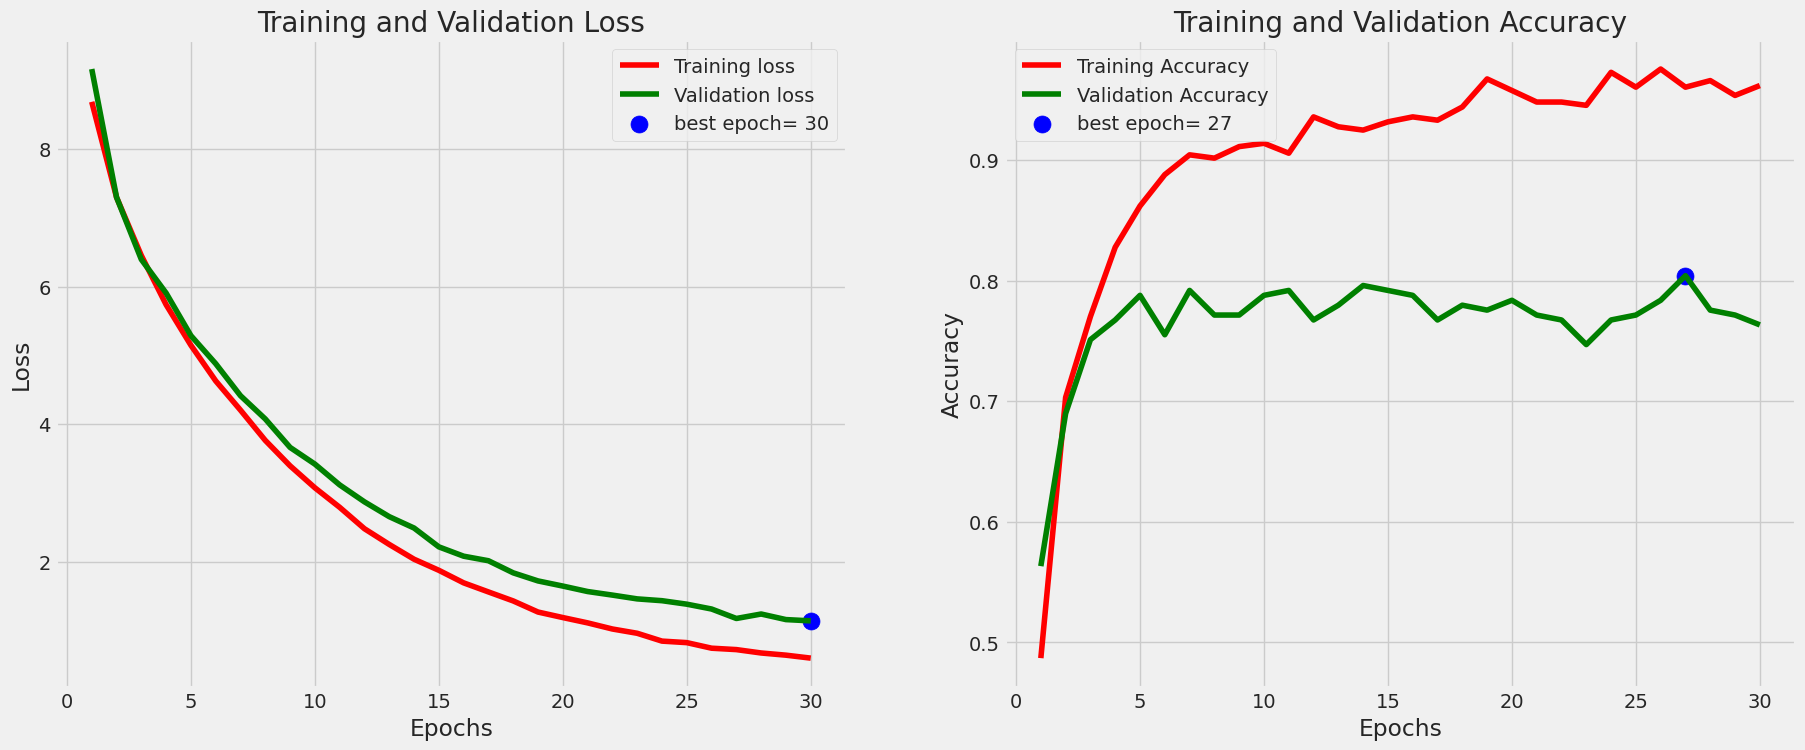

In [47]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate Model**

In [48]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

31/31 [==============================] - 2s 62ms/step - loss: 1.1368 - accuracy: 0.7633
Train Loss:  0.5325936675071716
Train Accuracy:  0.9849520921707153
--------------------
Test Loss:  1.136763095855713
Test Accuracy:  0.7632653117179871


**Get Prediction**

In [49]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrix**

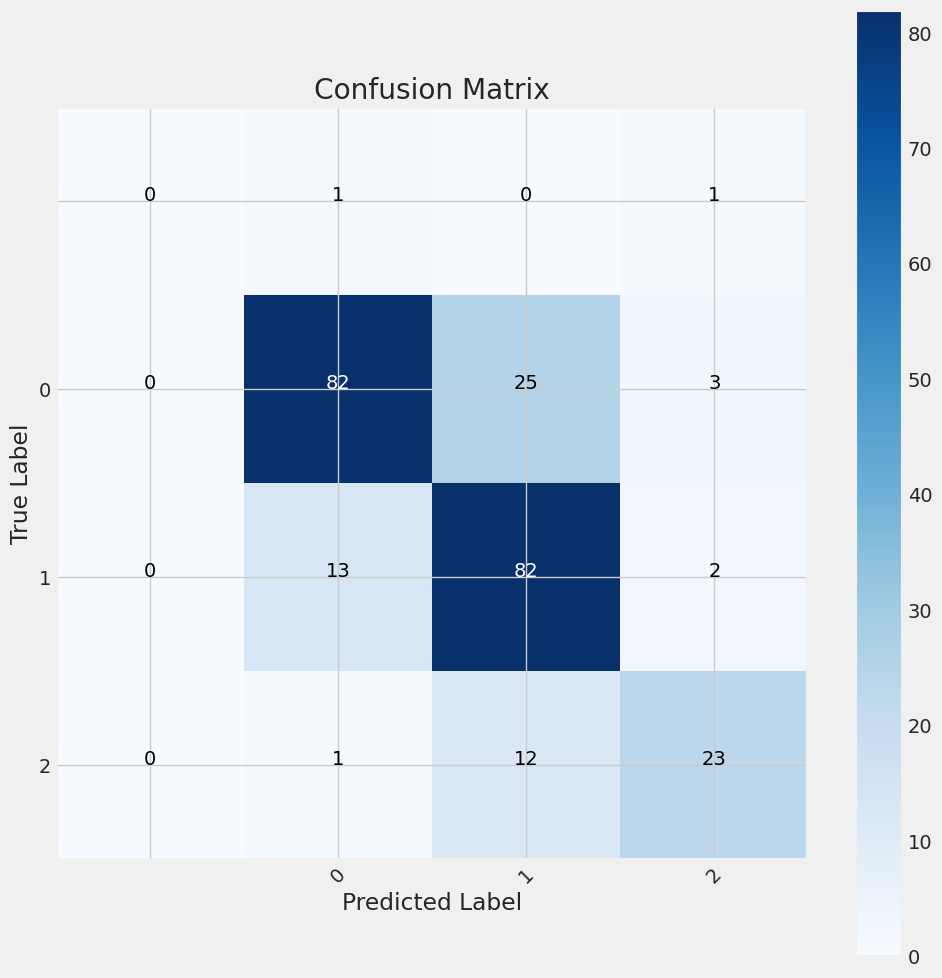

In [50]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**Classification Report**

In [51]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

                   0.00      0.00      0.00         2
           0       0.85      0.75      0.79       110
           1       0.69      0.85      0.76        97
           2       0.79      0.64      0.71        36

    accuracy                           0.76       245
   macro avg       0.58      0.56      0.56       245
weighted avg       0.77      0.76      0.76       245



In [55]:
model.save('Skin Cancer.h5')